In [18]:
# Import necessary libraries and packages
import time
import numpy as np
import pandas as pd

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

Total number of samples: 1797
Image dimensions: (8, 8)
Number of classes: 10


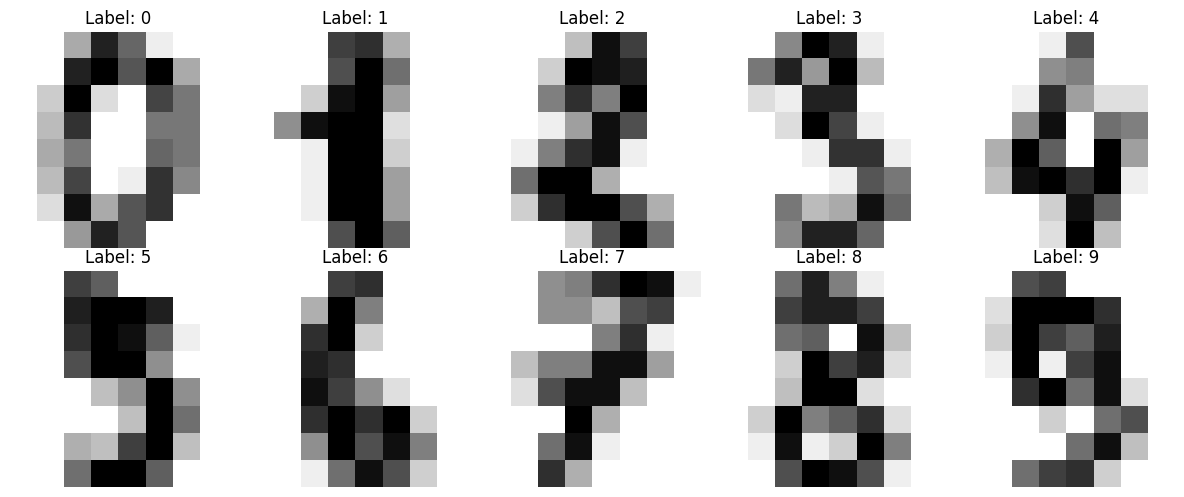

In [10]:
# Load MNIST dataset from sklearn
digits = datasets.load_digits()

# Get basic information about the dataset
n_samples = len(digits.images)
print(f"Total number of samples: {n_samples}")
print(f"Image dimensions: {digits.images[0].shape}")
print(f"Number of classes: {len(np.unique(digits.target))}")

# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Flatten the images
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1437, 64)
Testing set shape: (360, 64)


In [13]:
# Initialize the SVM classifier. Use RBF kernel which works well for image classification
svm_classifier = svm.SVC(kernel='rbf', C=1.0, gamma=0.001, probability=True)

# Train the model
print("Training SVM model...")
start_time = time.time()
svm_classifier.fit(X_train_scaled, y_train)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

# Predict on the test set
y_pred = svm_classifier.predict(X_test_scaled)

Training SVM model...
Model trained in 0.18 seconds


Accuracy: 0.9389
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.84      0.93      0.88        28
           2       0.94      0.94      0.94        33
           3       1.00      0.88      0.94        34
           4       1.00      1.00      1.00        46
           5       0.94      0.94      0.94        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.83      0.83      0.83        30
           9       0.90      0.90      0.90        40

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



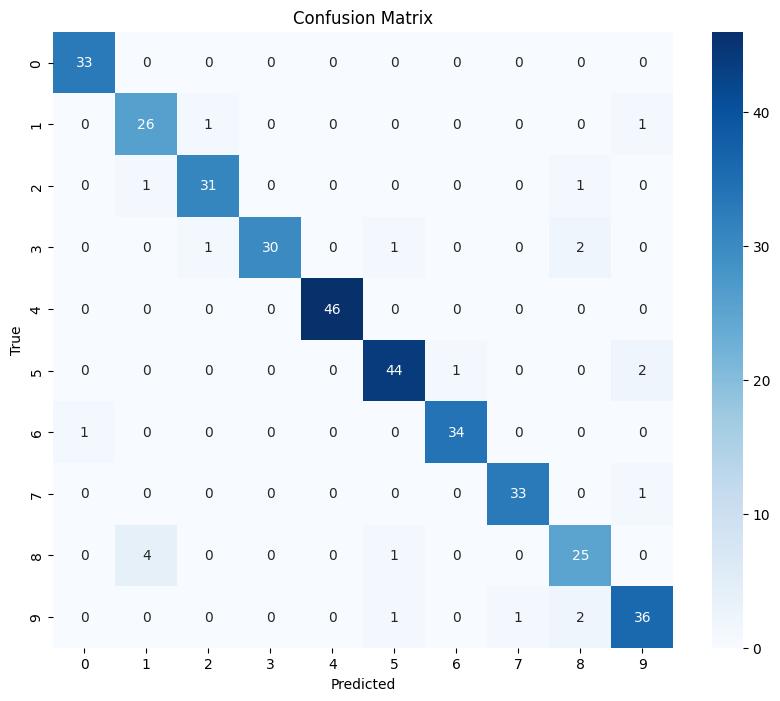

In [15]:
# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=digits.target_names if hasattr(digits, 'target_names') else range(10),
            yticklabels=digits.target_names if hasattr(digits, 'target_names') else range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('../outputs/confusion_matrix_svm.png', dpi=300, bbox_inches='tight')
plt.show()

Number of misclassified examples: 22


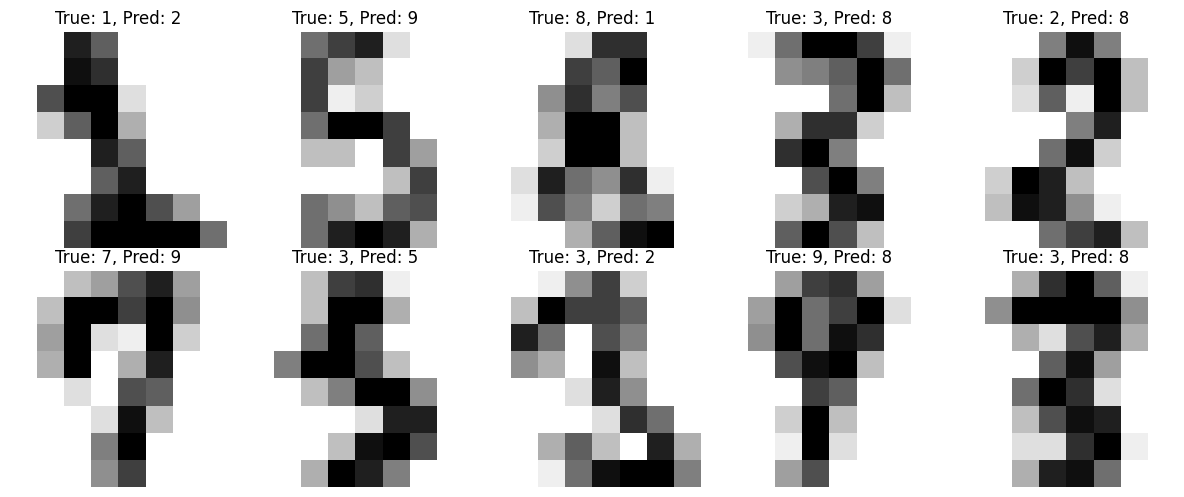

In [16]:
# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"Number of misclassified examples: {len(misclassified_idx)}")

# Display a few misclassified examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    if i < len(misclassified_idx):
        idx = misclassified_idx[i]
        ax.imshow(X_test[idx].reshape(8, 8), cmap='binary')
        ax.set_title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Test a few different parameter combinations
param_grid = [
    {'C': [0.1, 1, 10], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
]

# Use grid search to find the best parameters
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=3, n_jobs=-1)
print("Performing grid search...")
start_time = time.time()
grid_search.fit(X_train_scaled[:1000], y_train[:1000])  # Using subset for speed
search_time = time.time() - start_time
print(f"Grid search completed in {search_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Performing grid search...
Grid search completed in 5.09 seconds
Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.9710


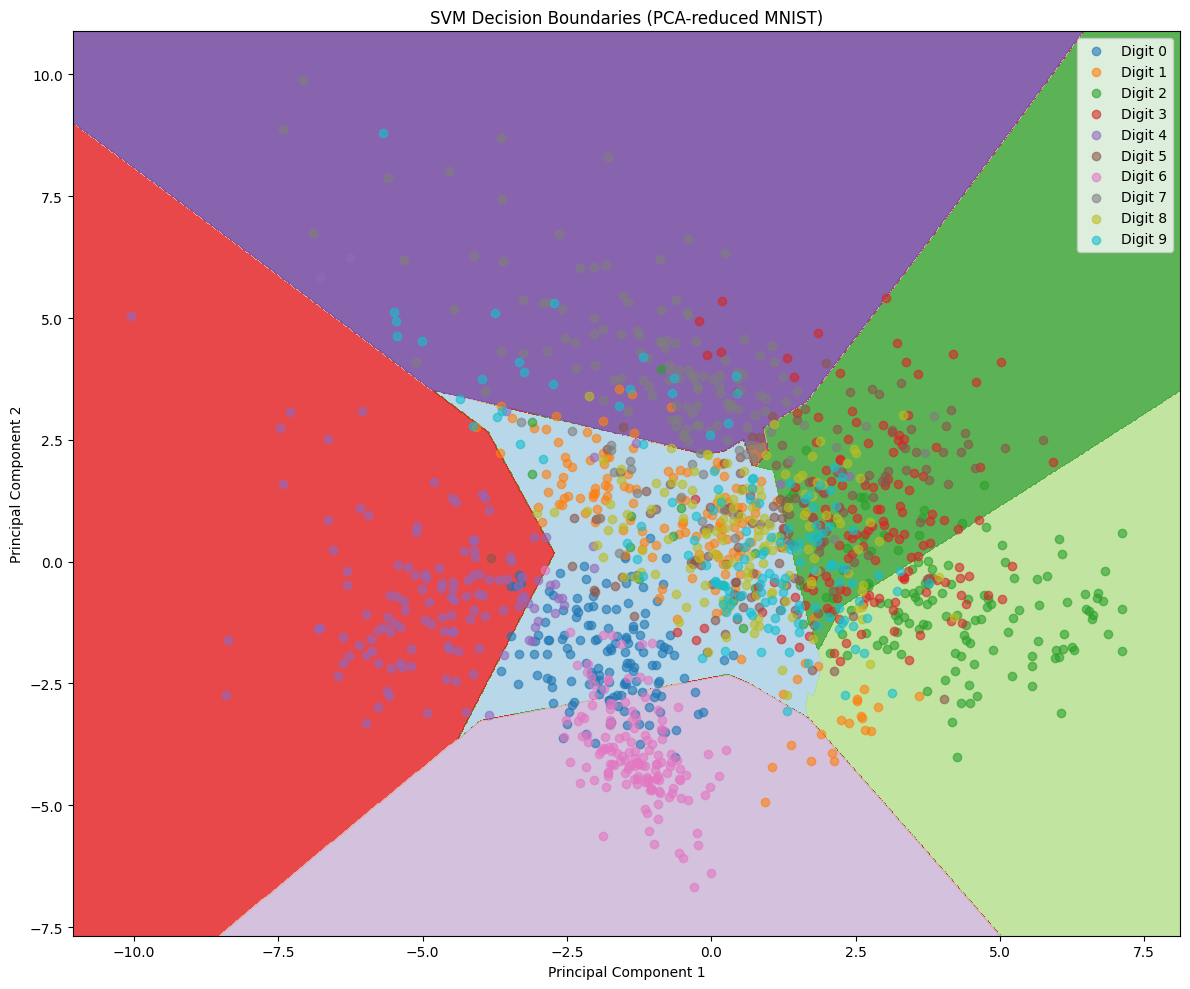

In [19]:
# Visualization of SVM decision boundaries

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a new SVM on the reduced data
svm_pca = svm.SVC(kernel='rbf', C=1.0, gamma=0.001)
svm_pca.fit(X_train_pca, y_train)

# Create a mesh grid
h = 0.02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot decision boundary
Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)

# Plot also the training points
for i in range(10):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], 
                label=f'Digit {i}', alpha=0.6)
plt.legend()
plt.title('SVM Decision Boundaries (PCA-reduced MNIST)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

## SVM Model for MNIST Digit Classification

### Introduction
In this notebook, we applied Support Vector Machine (SVM) classification to the MNIST handwritten digit dataset. The MNIST dataset consists of 8x8 pixel grayscale images of handwritten digits (0-9).

### Methodology
We used an SVM with an RBF kernel to classify the digits. The approach included:
1. Loading and preprocessing the MNIST dataset
2. Splitting the data into training and test sets (80%/20%)
3. Standardizing the features
4. Training an SVM model with RBF kernel
5. Grid search to find optimal parameters (C=10, gamma=0.001)
6. Evaluating model performance using confusion matrix and classification metrics

### Results
- The model achieved an overall accuracy of 93.89% on the test set
- Best performing digits: Digit 4 (100% precision and recall)
- Most challenging digits: Digit 8 (83% precision and recall)
- Common misclassifications:
  - 8s being classified as 1s (4 instances)
  - 3s being classified as 8s (2 instances)
  - 9s being classified as 8s (2 instances)

### Interpretation
The confusion matrix reveals the model's strengths and weaknesses:
- The diagonal elements show correctly classified instances
- Off-diagonal elements represent misclassifications
- Digits with similar visual features (like 8 and 1, or 3 and 8) tend to be confused more often
- The PCA visualization shows how the SVM creates decision boundaries in the reduced feature space

### SVM Concept in Relation to MNIST Data
Support Vector Machines work particularly well for MNIST because:
1. **High-dimensional data handling**: MNIST images (64 pixels) create a high-dimensional space where SVM excels
2. **Kernel trick**: The RBF kernel implicitly maps the digit features to a higher-dimensional space where they become more separable
3. **Margin maximization**: SVM finds the optimal hyperplane that maximizes the margin between digit classes, improving generalization
4. **Parameter tuning**: Grid search identified optimal C and gamma values for our data (C=10, gamma=0.001)

The SVM model effectively captures the distinctive features of each digit while being robust to the variations in handwriting styles present in the dataset.